# <center><font color=red>**Penyisihan Pesta Data Nasional (PeDaS) 2025**
## **Tim One For All (Universitas Mataram)**
- Fadlullah Hasan
- Muhamad Erwin Hariadinata
- I Nyoman Widiyasa Jayananda

## 🏆 **WON: 2ND ASPIRING WINNER** 🏆

# Setup and Importing Data

In [ ]:
import logging, warnings, os

for name in ["cmdstanpy", "prophet", "prophet.plot", "prophet.models", "pytorch_lightning", "darts.models", "stanpy", "pytorch"]:
    lg = logging.getLogger(name)
    lg.setLevel(logging.CRITICAL)
    lg.propagate = False
    for h in list(lg.handlers):
        lg.removeHandler(h)

warnings.filterwarnings("always", module="cmdstanpy")
warnings.filterwarnings("ignore", module="prophet")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if logger.hasHandlers():
    logger.handlers.clear()

console_handler = logging.StreamHandler()

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)
logger.info("Logging object initialized!")

2025-09-07 02:36:04,644 - root - INFO - Logging object initialized!


In [ ]:
try:
    import google.colab
    IN_COLAB = True
    !mkdir -p data results/models
    !wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1x_okHyggMa3oaHh5SskUYhcdASmHYfW5" -O data/dataCarSale2021-2025.csv
    !pip install darts nolds tsfresh seaborn prophet plotly ipywidgets scikit-learn --quiet
    logger.warning("Running code through Colab...")

except:
    IN_COLAB = False
    !mkdir -p data results/models
    !wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1x_okHyggMa3oaHh5SskUYhcdASmHYfW5" -O data/dataCarSale2021-2025.csv
    !pip install darts nolds tsfresh seaborn prophet plotly ipywidgets scikit-learn --quiet
    logger.warning("Running code locally...")

--2025-09-07 02:36:04--  https://docs.google.com/uc?export=download&id=1x_okHyggMa3oaHh5SskUYhcdASmHYfW5
Resolving docs.google.com (docs.google.com)... 74.125.24.139, 74.125.24.138, 74.125.24.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1x_okHyggMa3oaHh5SskUYhcdASmHYfW5&export=download [following]
--2025-09-07 02:36:05--  https://drive.usercontent.google.com/download?id=1x_okHyggMa3oaHh5SskUYhcdASmHYfW5&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.170.132, 2404:6800:4003:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2830 (2.8K) [application/octet-stream]
Saving to: ‘data/dataCarSale2021-2025.csv’

data/dataCarSale202 100%[===================>]   2.76K  --.-K

2025-09-07 02:36:36,706 - root - WARNING - Running code through Colab...


In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging
from pathlib import Path
import pickle
import os

import darts
from darts import TimeSeries
from darts.models import (
    AutoARIMA, Theta, FourTheta,
    VARIMA, AutoETS, Prophet,
    TBATS, AutoTBATS, ExponentialSmoothing,
    TFTModel
)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler as SKMinMax
from copy import deepcopy

2025-09-07 02:36:36,855 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [ ]:
seed = 404
np.random.seed(seed)
logger.info(f"Seed has been set to: {seed}!")

2025-09-07 02:37:09,791 - root - INFO - Seed has been set to: 404!


# Data Preprocessing

In [ ]:
def load_and_preprocess_data(file_path="data/dataCarSale2021-2025.csv"):
    logger.info("Loading car sales data...")
    Path("data").mkdir(exist_ok=True)
    df = pd.read_csv(file_path)
    df['waktu'] = pd.to_datetime(df['waktu'])
    df.set_index('waktu', inplace=True)

    df = df.asfreq('MS')

    if df.isnull().any().any():
        df = df.interpolate(method='linear')
        logger.warning("Missing values found and interpolated")

    logger.info(f"Data loaded successfully!")
    logger.info(f"Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    logger.info(f"Shape: {df.shape} ({df.shape[0]} months, {df.shape[1]} brands)")
    logger.info(f"Brands: {list(df.columns)}")

    return df

df = load_and_preprocess_data()

2025-09-07 02:37:09,799 - root - INFO - Loading car sales data...
2025-09-07 02:37:09,821 - root - WARNING - Missing values found and interpolated
2025-09-07 02:37:09,821 - root - INFO - Data loaded successfully!
2025-09-07 02:37:09,822 - root - INFO - Date range: 2021-01-01 to 2025-07-01
2025-09-07 02:37:09,823 - root - INFO - Shape: (55, 5) (55 months, 5 brands)
2025-09-07 02:37:09,823 - root - INFO - Brands: ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']


In [ ]:
df.head(15)

,DAIHATSU,HONDA,MITSUBISHI,SUZUKI,TOYOTA
waktu,,,,,
2021-01-01,8993.0,7231.0,9108.0,6400.0,15474.0
2021-02-01,9412.0,6812.0,7567.0,4600.0,14645.0
2021-03-01,16770.0,11350.0,13088.0,8669.0,26034.0
2021-04-01,15861.0,8474.0,13820.0,8100.0,22618.0
2021-05-01,8310.0,5832.0,10160.0,5341.0,17361.0
2021-06-01,15481.0,8782.0,8277.0,8965.0,22310.0
2021-07-01,9284.0,9030.0,13453.0,6274.0,20950.0
2021-08-01,14408.0,7337.0,13720.0,10021.0,28418.0
2021-09-01,17529.0,3453.0,12200.0,7515.0,32596.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55 entries, 2021-01-01 to 2025-07-01
Freq: MS
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    55 non-null     float64
 1   HONDA       55 non-null     float64
 2   MITSUBISHI  55 non-null     float64
 3   SUZUKI      55 non-null     float64
 4   TOYOTA      55 non-null     float64
dtypes: float64(5)
memory usage: 2.6 KB


In [ ]:
df.describe(include="all")

,DAIHATSU,HONDA,MITSUBISHI,SUZUKI,TOYOTA
count,55.000000,55.000000,55.000000,55.000000,55.000000
mean,11184.578291,7629.129009,8707.016736,5597.078182,19889.765155
std,4584.547394,3851.939687,3343.788910,2331.495381,7789.430726
min,5755.232000,1590.411000,4349.666000,2004.813000,7617.122000
25%,7436.549000,3880.832500,6160.500000,3232.610000,12642.791500
50%,9284.000000,7337.000000,7567.000000,5801.000000,20950.000000
75%,15603.000000,10735.500000,11583.000000,7513.500000,25856.000000
max,23165.000000,15993.000000,18211.000000,10021.000000,33153.000000


In [ ]:
def analyze_train_test_split(df, train_ratios=[0.7, 0.75, 0.8, 0.85, 0.87]):
    total_months = len(df)

    print("🔄 TRAIN-TEST SPLIT ANALYSIS")
    print("="*50)
    print(f"Total months available: {total_months}")

    for ratio in train_ratios:
        train_months = int(total_months * ratio)
        test_months = total_months - train_months

        train_end = df.index[train_months - 1]
        test_start = df.index[train_months]
        test_end = df.index[-1]

        print(f"\n📊 Split Ratio: {ratio:.1%}")
        print(f"   Train: {train_months} months ({df.index[0].strftime('%Y-%m')} to {train_end.strftime('%Y-%m')})")
        print(f"   Test:  {test_months} months ({test_start.strftime('%Y-%m')} to {test_end.strftime('%Y-%m')})")

    return train_ratios

analyze_train_test_split(df)

TRAIN_RATIO = 0.85

🔄 TRAIN-TEST SPLIT ANALYSIS
Total months available: 55

📊 Split Ratio: 70.0%
   Train: 38 months (2021-01 to 2024-02)
   Test:  17 months (2024-03 to 2025-07)

📊 Split Ratio: 75.0%
   Train: 41 months (2021-01 to 2024-05)
   Test:  14 months (2024-06 to 2025-07)

📊 Split Ratio: 80.0%
   Train: 44 months (2021-01 to 2024-08)
   Test:  11 months (2024-09 to 2025-07)

📊 Split Ratio: 85.0%
   Train: 46 months (2021-01 to 2024-10)
   Test:  9 months (2024-11 to 2025-07)

📊 Split Ratio: 87.0%
   Train: 47 months (2021-01 to 2024-11)
   Test:  8 months (2024-12 to 2025-07)


In [ ]:
def canonicalize_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()

    if "waktu" in df.columns:
        df["waktu"] = pd.to_datetime(df["waktu"], errors="coerce")
        df = df.set_index("waktu")
    else:
        df.index = pd.to_datetime(df.index, errors="coerce")

    df = df.sort_index()
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()

    full = pd.date_range(df.index.min(), df.index.max(), freq="MS")
    df = df.reindex(full)

    df = df.apply(pd.to_numeric, errors="coerce").astype("float64")

    df = df.interpolate(method="time")
    df = df.bfill().ffill()

    df.index.name = "waktu"

    assert isinstance(df.index, pd.DatetimeIndex), "Index must be DatetimeIndex"
    assert df.index.freq is None or df.index.freqstr in ("MS", "M", "ME"), "Index should be monthly"
    assert not df.isna().any().any(), "No NaNs should remain"

    return df

df = canonicalize_df(df)

In [ ]:
from darts import TimeSeries

def time_series_objects(df: pd.DataFrame):
    logger.info("Creating TimeSeries objects...")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df.index must be DatetimeIndex. Run canonicalize_df(df) first.")

    series_dict = {}
    for brand in df.columns:
        s = df[brand].astype("float64")
        ts = TimeSeries.from_series(s, fill_missing_dates=True, freq="MS")
        if not isinstance(ts.time_index, pd.DatetimeIndex):
            raise ValueError(f"{brand}: TimeSeries.time_index is not DatetimeIndex")
        series_dict[brand] = ts

    mv_series = TimeSeries.from_dataframe(
        df=df,
        value_cols=list(df.columns),
        fill_missing_dates=True,
        freq="MS",
    )
    if not isinstance(mv_series.time_index, pd.DatetimeIndex):
        raise ValueError("Multivariate series time_index is not DatetimeIndex")

    logger.info(f"Created {len(series_dict)} individual series")
    logger.info(f"Created multivariate series with {len(mv_series.components)} components")

    return series_dict, mv_series

series_dict, mv_series = time_series_objects(df)

2025-09-07 02:37:09,943 - root - INFO - Creating TimeSeries objects...
2025-09-07 02:37:10,029 - root - INFO - Created 5 individual series
2025-09-07 02:37:10,030 - root - INFO - Created multivariate series with 5 components


In [ ]:
def validate_series_dict(series_dict):
    for brand, ts in series_dict.items():
        bad_idx = [i for i in ts.time_index if isinstance(i, str)]
        if bad_idx:
            raise ValueError(
                f"❌ Brand {brand}: found {len(bad_idx)} str indices. "
                f"Examples: {bad_idx[:3]}"
            )
        if not isinstance(ts.time_index, pd.DatetimeIndex):
            raise ValueError(
                f"❌ Brand {brand}: time_index is {type(ts.time_index)}, not DatetimeIndex."
            )
        print(f"✅ {brand}: {len(ts)} points, index OK ({ts.freq_str})")
    print("🎉 All series passed: no string indices anywhere.")

validate_series_dict(series_dict)

✅ DAIHATSU: 55 points, index OK (MS)
✅ HONDA: 55 points, index OK (MS)
✅ MITSUBISHI: 55 points, index OK (MS)
✅ SUZUKI: 55 points, index OK (MS)
✅ TOYOTA: 55 points, index OK (MS)
🎉 All series passed: no string indices anywhere.


# Helpers

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as SM_HW

class HWNative:
    def __init__(self, trend='add', seasonal='add', seasonal_periods=12, damped_trend=None):
        self.trend = trend
        self.seasonal = seasonal
        self.seasonal_periods = int(seasonal_periods)
        self.damped_trend = damped_trend
        self._res = None
        self._train_index = None

    def untrained_copy(self):
        return HWNative(
            trend=self.trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods,
            damped_trend=self.damped_trend,
        )

    def fit(self, ts: TimeSeries):
        if ts.width != 1:
            raise ValueError("HWNative expects a UNIVARIATE TimeSeries (width == 1).")

        vals = ts.values(copy=False).squeeze()
        idx = ts.time_index
        s = pd.Series(vals.astype(np.float64), index=pd.DatetimeIndex(idx))

        if not isinstance(s.index, pd.DatetimeIndex):
            raise ValueError("TimeSeries must have a DatetimeIndex.")
        if s.index.freq is None:
            s = s.asfreq("MS")
            if s.index.freq is None:
                s.index = pd.date_range(s.index.min(), s.index.max(), freq="MS")

        self._train_index = s.index

        model = SM_HW(
            s,
            trend=self.trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods,
            damped_trend=self.damped_trend,
        )
        self._res = model.fit(optimized=True)
        return self

    def predict(self, n: int) -> TimeSeries:
        if self._res is None:
            raise RuntimeError("Call fit() before predict().")

        fc = self._res.forecast(n)

        if isinstance(fc, np.ndarray):
            start = self._train_index[-1] + pd.offsets.MonthBegin(1)
            idx = pd.date_range(start=start, periods=n, freq="MS")
            fc = pd.Series(fc.astype(np.float64), index=idx)
        else:
            fc.index = pd.DatetimeIndex(fc.index)
            if fc.index.freq is None:
                start = self._train_index[-1] + pd.offsets.MonthBegin(1)
                fc.index = pd.date_range(start=start, periods=n, freq="MS")

        return TimeSeries.from_series(fc, fill_missing_dates=True, freq="MS")

In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

def build_future_covariates(series: TimeSeries, horizon: int) -> TimeSeries:
    start = series.start_time()
    end   = series.end_time() + pd.offsets.MonthBegin(horizon)

    full_idx = pd.date_range(start=start, end=end, freq="MS")

    month_ohe = datetime_attribute_timeseries(
        time_index=full_idx,
        attribute="month",
        one_hot=True
    )

    year_num = datetime_attribute_timeseries(
        time_index=full_idx,
        attribute="year",
        one_hot=False
    )

    cov = month_ohe.stack(year_num)
    return cov

In [ ]:
def choose_scaler(model_name: str):
    if any(k in model_name for k in ["Theta","ETS","ExponentialSmoothing"]):
        return Scaler(scaler=SKMinMax())
    return Scaler()

# Model Setup

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="train_loss", mode="min", patience=10
)

def uni_models():
    models = {
        "AutoARIMA": AutoARIMA(
            seasonal=True,
            stepwise=True,
            max_p=5, max_q=5, max_P=2, max_Q=2
        ),


        "Prophet": Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode="multiplicative",
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=0.01,
            holidays_prior_scale=0.01,
            changepoint_range=0.9,
            n_changepoints=25,
            interval_width=0.8
        ),

        "ExponentialSmoothing": HWNative(
            seasonal_periods=12,
            trend="add",
            seasonal="add"
        ),

        "Theta": Theta(season_mode=SeasonalityMode.ADDITIVE),

        "FourTheta": FourTheta(season_mode=SeasonalityMode.ADDITIVE),

        "AutoETS": AutoETS(
            season_length=12,
            model='ZZZ'
        ),

        "TBATS": TBATS(
            season_length=12,
            use_trend=True,
            use_damped_trend=False,
            use_arma_errors=False
        ),

        "TFTModel": TFTModel(
            input_chunk_length=24,
            output_chunk_length=6,
            hidden_size=16,
            lstm_layers=1,
            num_attention_heads=4,
            dropout=0.15,
            batch_size=16,
            n_epochs=200,
            random_state=42,
            likelihood=None,
            add_encoders={
                "cyclic": {"future": ["month"]},
                "datetime_attribute": {"future": ["year"]},
                "position": {"future": ["relative"]},
            },
            optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-4},
            pl_trainer_kwargs={
                "accelerator": "gpu",
                "devices": -1,
                "callbacks": [early_stop],
                "enable_progress_bar": False,
                "logger": False
            },
        )
    }

    print("MODELS USES:")
    print("="*50)
    for name, model in models.items():
        print(f"{name}")

    return models

models = uni_models()

MODELS USES:
AutoARIMA
Prophet
ExponentialSmoothing
Theta
FourTheta
AutoETS
TBATS
TFTModel


# Training Models

In [ ]:
def train_uni_models(series_dict, models, train_ratio=TRAIN_RATIO):
    logger.info("🚂 Starting univariate model training...")

    results = []
    predictions_dict = {}

    for brand, series in series_dict.items():
        print(f"\n🏷️  Processing brand: {brand}")
        print("-" * 30)

        try:
            train, test = series.split_after(train_ratio)
            print(f"📊 Train: {len(train)} months, Test: {len(test)} months")


            brand_predictions = {}

            for model_name, model in models.items():
                scaler = choose_scaler(model_name)
                scaler.fit(train)
                train_scaled = scaler.transform(train)
                try:
                    m = model.untrained_copy() if hasattr(model, "untrained_copy") else deepcopy(model)

                    if "TFT" in model_name:
                        horizon = len(test)
                        cov = build_future_covariates(series, horizon)

                        cov_train = cov.slice_intersect(train)
                        cov_full  = cov

                        cov_scaler = Scaler()
                        cov_train_s = cov_scaler.fit_transform(cov_train)
                        cov_full_s  = cov_scaler.transform(cov_full)


                        m.fit(train_scaled, future_covariates=cov_train_s, verbose=False)
                        pred_scaled = m.predict(horizon, future_covariates=cov_full_s)

                    else:
                        m.fit(train_scaled)
                        pred_scaled = m.predict(len(test))

                    pred = scaler.inverse_transform(pred_scaled)

                    smape_score = smape(test, pred)

                    results.append({
                        "brand": brand,
                        "model": model_name,
                        "sMAPE": float(smape_score)
                    })

                    brand_predictions[model_name] = {
                        'model': m,
                        'scaler': scaler,
                        'prediction': pred,
                        'sMAPE': float(smape_score)
                    }

                    print(f"   ✅ {model_name:15s}: sMAPE = {smape_score:.2f}%")

                except Exception as e:
                    print(f"   ❌ {model_name:15s}: Failed - {str(e)}...")
                    continue

            if brand_predictions:
                best_model = min(brand_predictions.items(), key=lambda x: x[1]['sMAPE'])
                predictions_dict[brand] = best_model[1]
                print(f"   🏆 Best model for {brand}: {best_model[0]} (sMAPE: {best_model[1]['sMAPE']:.2f}%)")

        except Exception as e:
            print(f"   ❌ Failed to process {brand}: {e}")
            continue

    return pd.DataFrame(results), predictions_dict

print("🚂 TRAINING UNIVARIATE MODELS")
print("="*50)
results_df, best_models_dict = train_uni_models(series_dict, models, TRAIN_RATIO)

if not results_df.empty:
    print(f"\n📊 UNIVARIATE MODELS PERFORMANCE SUMMARY")
    print("="*50)

    avg_performance = results_df.groupby('model')['sMAPE'].agg(['mean', 'std']).round(2)
    avg_performance = avg_performance.sort_values('mean')
    print("🏆 Overall Model Ranking (Average sMAPE across all brands):")
    print(avg_performance)

    print(f"\n🎯 Best Model per Brand:")
    best_per_brand = results_df.loc[results_df.groupby('brand')['sMAPE'].idxmin()]
    for _, row in best_per_brand.iterrows():
        print(f"   {row['brand']:12s}: {row['model']:15s} (sMAPE: {row['sMAPE']:.2f}%)")

2025-09-07 02:37:10,224 - root - INFO - 🚂 Starting univariate model training...


🚂 TRAINING UNIVARIATE MODELS

🏷️  Processing brand: DAIHATSU
------------------------------
📊 Train: 46 months, Test: 9 months
   ✅ AutoARIMA      : sMAPE = 14.34%


02:37:10 - cmdstanpy - INFO - Chain [1] start processing
02:37:11 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Prophet        : sMAPE = 8.37%
   ✅ ExponentialSmoothing: sMAPE = 28.61%
   ✅ Theta          : sMAPE = 17.13%
   ✅ FourTheta      : sMAPE = 17.13%
   ✅ AutoETS        : sMAPE = 14.57%
   ✅ TBATS          : sMAPE = 23.67%


02:37:39 - cmdstanpy - INFO - Chain [1] start processing


   ✅ TFTModel       : sMAPE = 20.02%
   🏆 Best model for DAIHATSU: Prophet (sMAPE: 8.37%)

🏷️  Processing brand: HONDA
------------------------------
📊 Train: 46 months, Test: 9 months
   ✅ AutoARIMA      : sMAPE = 40.66%


02:37:39 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Prophet        : sMAPE = 78.54%
   ✅ ExponentialSmoothing: sMAPE = 42.67%
   ✅ Theta          : sMAPE = 37.34%
   ✅ FourTheta      : sMAPE = 37.27%
   ✅ AutoETS        : sMAPE = 40.62%
   ✅ TBATS          : sMAPE = 41.89%
   ✅ TFTModel       : sMAPE = 83.75%
   🏆 Best model for HONDA: FourTheta (sMAPE: 37.27%)

🏷️  Processing brand: MITSUBISHI
------------------------------
📊 Train: 46 months, Test: 9 months


02:37:45 - cmdstanpy - INFO - Chain [1] start processing
02:37:45 - cmdstanpy - INFO - Chain [1] done processing


   ✅ AutoARIMA      : sMAPE = 10.15%
   ✅ Prophet        : sMAPE = 43.78%
   ✅ ExponentialSmoothing: sMAPE = 32.52%
   ✅ Theta          : sMAPE = 19.49%
   ✅ FourTheta      : sMAPE = 19.60%
   ✅ AutoETS        : sMAPE = 9.79%
   ✅ TBATS          : sMAPE = 13.27%
   ✅ TFTModel       : sMAPE = 22.58%
   🏆 Best model for MITSUBISHI: AutoETS (sMAPE: 9.79%)

🏷️  Processing brand: SUZUKI
------------------------------
📊 Train: 46 months, Test: 9 months


02:37:57 - cmdstanpy - INFO - Chain [1] start processing
02:37:57 - cmdstanpy - INFO - Chain [1] done processing


   ✅ AutoARIMA      : sMAPE = 22.21%
   ✅ Prophet        : sMAPE = 14.81%
   ✅ ExponentialSmoothing: sMAPE = 145.49%
   ✅ Theta          : sMAPE = 25.36%
   ✅ FourTheta      : sMAPE = 26.07%
   ✅ AutoETS        : sMAPE = 173.89%
   ✅ TBATS          : sMAPE = 176.82%
   ✅ TFTModel       : sMAPE = 37.85%
   🏆 Best model for SUZUKI: Prophet (sMAPE: 14.81%)

🏷️  Processing brand: TOYOTA
------------------------------
📊 Train: 46 months, Test: 9 months


02:38:05 - cmdstanpy - INFO - Chain [1] start processing
02:38:05 - cmdstanpy - INFO - Chain [1] done processing


   ✅ AutoARIMA      : sMAPE = 23.61%
   ✅ Prophet        : sMAPE = 20.45%
   ✅ ExponentialSmoothing: sMAPE = 149.71%
   ✅ Theta          : sMAPE = 25.05%
   ✅ FourTheta      : sMAPE = 25.04%
   ✅ AutoETS        : sMAPE = 23.18%
   ✅ TBATS          : sMAPE = 168.65%
   ✅ TFTModel       : sMAPE = 45.88%
   🏆 Best model for TOYOTA: Prophet (sMAPE: 20.45%)

📊 UNIVARIATE MODELS PERFORMANCE SUMMARY
🏆 Overall Model Ranking (Average sMAPE across all brands):
                       mean    std
model                             
AutoARIMA             22.19  11.72
Theta                 24.87   7.82
FourTheta             25.02   7.79
Prophet               33.19  28.66
TFTModel              42.01  25.67
AutoETS               52.41  68.92
ExponentialSmoothing  79.80  62.12
TBATS                 84.86  80.92

🎯 Best Model per Brand:
   DAIHATSU    : Prophet         (sMAPE: 8.37%)
   HONDA       : FourTheta       (sMAPE: 37.27%)
   MITSUBISHI  : AutoETS         (sMAPE: 9.79%)
   SUZUKI      : Prophet 

In [ ]:
def train_varima_model(mv_series, train_ratio=TRAIN_RATIO):
    logger.info("Training VARIMA multivariate model...")

    try:
        train_mv, test_mv = mv_series.split_after(train_ratio)
        print(f"VARIMA - Train: {len(train_mv)} months, Test: {len(test_mv)} months")

        scaler_mv = Scaler()
        scaler_mv.fit(train_mv)
        train_mv_scaled = scaler_mv.transform(train_mv)

        print("🔧 Fitting VARIMA model...")
        varima = VARIMA()
        varima.fit(train_mv_scaled)

        pred_scaled = varima.predict(len(test_mv))
        pred = scaler_mv.inverse_transform(pred_scaled)

        smape_scores = {}
        for brand in mv_series.components:
            score = smape(test_mv[brand], pred[brand])
            smape_scores[brand] = float(score)

        avg_smape = np.mean(list(smape_scores.values()))

        print(f"VARIMA completed!")
        print(f"Individual brand sMAPE scores:")
        for brand, score in smape_scores.items():
            print(f"   {brand:12s}: {score:.2f}%")
        print(f"Average sMAPE: {avg_smape:.2f}%")

        return {
            'model': varima,
            'scaler': scaler_mv,
            'prediction': pred,
            'test_data': test_mv,
            'smape_scores': smape_scores,
            'avg_smape': avg_smape
        }

    except Exception as e:
        print(f"VARIMA training failed: {e}")
        return None

print("TRAINING VARIMA MODEL")
print("="*50)
varima_results = train_varima_model(mv_series, TRAIN_RATIO)

2025-09-07 02:38:11,147 - root - INFO - Training VARIMA multivariate model...


TRAINING VARIMA MODEL
VARIMA - Train: 46 months, Test: 9 months
🔧 Fitting VARIMA model...
VARIMA completed!
Individual brand sMAPE scores:
   DAIHATSU    : 8.11%
   HONDA       : 33.40%
   MITSUBISHI  : 23.30%
   SUZUKI      : 16.66%
   TOYOTA      : 20.80%
Average sMAPE: 20.45%


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
def create_ml_features(df, max_lag=6):
    logger.info("Creating ML features...")

    df_featured = df.copy()

    for brand in df.columns:
        for lag in range(1, max_lag + 1):
            df_featured[f'{brand}_lag_{lag}'] = df_featured[brand].shift(lag)

    df_featured['month'] = df_featured.index.month
    df_featured['quarter'] = df_featured.index.quarter
    df_featured['year'] = df_featured.index.year
    df_featured['is_year_end'] = (df_featured.index.month == 12).astype(int)
    df_featured['is_year_start'] = (df_featured.index.month == 1).astype(int)

    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured.index.month / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured.index.month / 12)

    for brand in df.columns:
        df_featured[f'{brand}_roll_mean_3'] = df_featured[brand].rolling(3, min_periods=1).mean()
        df_featured[f'{brand}_roll_std_3'] = df_featured[brand].rolling(3, min_periods=1).std()

    df_featured = df_featured.dropna()

    print(f"✅ Created {df_featured.shape[1]} features from {df.shape[1]} original columns")
    print(f"📊 Feature dataset shape: {df_featured.shape}")

    return df_featured

def train_xgboost_model(df, max_lag=6):
    logger.info("Training XGBoost model...")

    df_featured = create_ml_features(df, max_lag)

    target_cols = df.columns.tolist()
    feature_cols = [col for col in df_featured.columns if col not in target_cols]

    X = df_featured[feature_cols]
    y = df_featured[target_cols]

    split_idx = int(len(df_featured) * TRAIN_RATIO)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"📊 XGBoost - Train: {X_train.shape[0]} months, Test: {X_test.shape[0]} months")
    print(f"🔧 Features: {len(feature_cols)}")

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed,
        n_jobs=-1
    )

    multi_output_model = MultiOutputRegressor(xgb_model)
    multi_output_model.fit(X_train, y_train)

    y_pred = multi_output_model.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

    def smape_sklearn(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        return np.mean(np.where(denominator == 0, 0, numerator / denominator)) * 100

    smape_scores = {}
    for brand in y_test.columns:
        score = smape_sklearn(y_test[brand], y_pred_df[brand])
        smape_scores[brand] = score

    avg_smape = np.mean(list(smape_scores.values()))

    print(f"XGBoost completed!")
    print(f"Individual brand sMAPE scores:")
    for brand, score in smape_scores.items():
        print(f"   {brand:12s}: {score:.2f}%")
    print(f"Average sMAPE: {avg_smape:.2f}%")

    try:
        importance = multi_output_model.estimators_[0].feature_importances_
        feature_importance = dict(zip(feature_cols, importance))
        top_features = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10])

        print(f"\n🔍 Top 10 Most Important Features:")
        for feature, importance in top_features.items():
            print(f"   {feature:25s}: {importance:.4f}")
    except:
        top_features = {}

    return {
        'model': multi_output_model,
        'predictions': y_pred_df,
        'actual': y_test,
        'smape_scores': smape_scores,
        'avg_smape': avg_smape,
        'feature_importance': top_features,
        'feature_cols': feature_cols,
        'df_featured': df_featured
    }

print("TRAINING XGBOOST MODEL")
print("="*50)
xgb_results = train_xgboost_model(df, max_lag=6)

2025-09-07 02:38:12,548 - root - INFO - Training XGBoost model...
2025-09-07 02:38:12,556 - root - INFO - Creating ML features...


TRAINING XGBOOST MODEL
✅ Created 52 features from 5 original columns
📊 Feature dataset shape: (49, 52)
📊 XGBoost - Train: 41 months, Test: 8 months
🔧 Features: 47
XGBoost completed!
Individual brand sMAPE scores:
   DAIHATSU    : 17.43%
   HONDA       : 42.82%
   MITSUBISHI  : 16.09%
   SUZUKI      : 17.52%
   TOYOTA      : 25.95%
Average sMAPE: 23.96%

🔍 Top 10 Most Important Features:
   SUZUKI_roll_mean_3       : 0.3438
   MITSUBISHI_roll_mean_3   : 0.2616
   DAIHATSU_roll_mean_3     : 0.1252
   TOYOTA_roll_mean_3       : 0.0699
   year                     : 0.0409
   SUZUKI_lag_1             : 0.0395
   MITSUBISHI_lag_3         : 0.0211
   TOYOTA_lag_5             : 0.0166
   DAIHATSU_roll_std_3      : 0.0115
   HONDA_lag_5              : 0.0085


In [ ]:
def forecast_next_month():
    target_date = pd.Timestamp('2025-08-01')
    print(f"GENERATING FORECASTS FOR {target_date.strftime('%Y-%m-%d')}")
    print("="*60)

    forecasts = {}
    smape_scores = {}
    best_forecasts = {}

    if best_models_dict:
        print("Method 1: Best Univariate Model per Brand")
        print("-" * 40)
        univariate_forecasts = {}
        smape_scores['Univariate'] = {}
        for brand, model_info in best_models_dict.items():
            try:
                full_series = series_dict[brand]
                scaler = Scaler()
                scaler.fit(full_series)
                full_series_scaled = scaler.transform(full_series)

                model = model_info['model']
                model.fit(full_series_scaled)
                forecast_scaled = model.predict(1)
                forecast = scaler.inverse_transform(forecast_scaled)
                forecast_value = forecast.values().flatten()[0]

                univariate_forecasts[brand] = int(round(forecast_value))
                smape_scores['Univariate'][brand] = model_info['sMAPE']

                print(f"   {brand:12s}: {forecast_value:8.0f} units (sMAPE {model_info['sMAPE']:.2f}%)")
            except Exception as e:
                print(f"   {brand:12s}: Failed - {e}")
                univariate_forecasts[brand] = None
                smape_scores['Univariate'][brand] = np.inf
        forecasts['Univariate'] = univariate_forecasts

    if varima_results:
        print(f"\nMethod 2: VARIMA Multivariate")
        print("-" * 40)
        try:
            scaler_mv = Scaler()
            scaler_mv.fit(mv_series)
            mv_series_scaled = scaler_mv.transform(mv_series)

            varima_full = VARIMA()
            varima_full.fit(mv_series_scaled)
            forecast_scaled = varima_full.predict(1)
            forecast = scaler_mv.inverse_transform(forecast_scaled)

            varima_forecasts = {}
            smape_scores['VARIMA'] = {}
            for i, brand in enumerate(mv_series.components):
                forecast_value = forecast.values()[0, i]
                varima_forecasts[brand] = int(round(forecast_value))
                smape_scores['VARIMA'][brand] = varima_results['smape_scores'].get(brand, np.inf)
                print(f"   {brand:12s}: {forecast_value:8.0f} units")
            forecasts['VARIMA'] = varima_forecasts
        except Exception as e:
            print(f"   VARIMA forecast failed: {e}")

    if xgb_results:
        print(f"\nMethod 3: XGBoost Machine Learning")
        print("-" * 40)
        try:
            df_featured = xgb_results['df_featured']
            feature_cols = xgb_results['feature_cols']

            last_data = df.iloc[-6:]
            next_month_features = {}
            for brand in df.columns:
                for lag in range(1, 7):
                    if lag <= len(last_data):
                        next_month_features[f'{brand}_lag_{lag}'] = last_data[brand].iloc[-lag]
                    else:
                        next_month_features[f'{brand}_lag_{lag}'] = last_data[brand].iloc[0]
            next_month_features.update({
                'month': 8,
                'quarter': 3,
                'year': 2025,
                'is_year_end': 0,
                'is_year_start': 0,
                'month_sin': np.sin(2 * np.pi * 8 / 12),
                'month_cos': np.cos(2 * np.pi * 8 / 12)
            })
            for brand in df.columns:
                next_month_features[f'{brand}_roll_mean_3'] = last_data[brand].mean()
                next_month_features[f'{brand}_roll_std_3'] = last_data[brand].std()

            X_next = pd.DataFrame([next_month_features])[feature_cols]
            prediction = xgb_results['model'].predict(X_next)

            xgb_forecasts = {}
            smape_scores['XGBoost'] = {}
            for i, brand in enumerate(df.columns):
                forecast_value = prediction[0][i]
                xgb_forecasts[brand] = int(round(forecast_value))
                smape_scores['XGBoost'][brand] = xgb_results['smape_scores'].get(brand, np.inf)
                print(f"   {brand:12s}: {forecast_value:8.0f} units")
            forecasts['XGBoost'] = xgb_forecasts
        except Exception as e:
            print(f"   XGBoost forecast failed: {e}")

    print("\nFINAL FORECASTS PER BRAND")
    print("="*60)
    total_forecast = 0
    for brand in df.columns:
        best_method = None
        best_smape = np.inf
        best_value = None
        for method in forecasts:
            value = forecasts[method].get(brand)
            score = smape_scores.get(method, {}).get(brand, np.inf)
            if value is not None and score < best_smape:
                best_method = method
                best_smape = score
                best_value = value
        best_forecasts[brand] = best_value
        if best_value is not None:
            print(f"📊 {brand:12s}: {best_value:,} units (from {best_method}, sMAPE {best_smape:.2f}%)")
            total_forecast += best_value
        else:
            print(f"📊 {brand:12s}: N/A")
    print(f"\n🎯 TOTAL MARKET FORECAST: {total_forecast:,} units")

    return best_forecasts, forecasts, smape_scores

print("\n" + "="*80)
print("FINAL FORECASTING PHASE")
print("="*80)

final_forecasts, ensemble_forecasts, forecast_summary = forecast_next_month()

02:38:13 - cmdstanpy - INFO - Chain [1] start processing
02:38:13 - cmdstanpy - INFO - Chain [1] done processing



FINAL FORECASTING PHASE
GENERATING FORECASTS FOR 2025-08-01
Method 1: Best Univariate Model per Brand
----------------------------------------
   DAIHATSU    :     5881 units (sMAPE 8.37%)
   HONDA       :     3256 units (sMAPE 37.27%)


02:38:13 - cmdstanpy - INFO - Chain [1] start processing
02:38:13 - cmdstanpy - INFO - Chain [1] done processing
02:38:13 - cmdstanpy - INFO - Chain [1] start processing


   MITSUBISHI  :     6207 units (sMAPE 9.79%)
   SUZUKI      :     2351 units (sMAPE 14.81%)


02:38:13 - cmdstanpy - INFO - Chain [1] done processing


   TOYOTA      :    10805 units (sMAPE 20.45%)

Method 2: VARIMA Multivariate
----------------------------------------
   DAIHATSU    :     6274 units
   HONDA       :     3434 units
   MITSUBISHI  :     4859 units
   SUZUKI      :     2690 units
   TOYOTA      :     9746 units

Method 3: XGBoost Machine Learning
----------------------------------------
   DAIHATSU    :     7794 units
   HONDA       :     4594 units
   MITSUBISHI  :     5792 units
   SUZUKI      :     2980 units
   TOYOTA      :    11557 units

FINAL FORECASTS PER BRAND
📊 DAIHATSU    : 6,274 units (from VARIMA, sMAPE 8.11%)
📊 HONDA       : 3,434 units (from VARIMA, sMAPE 33.40%)
📊 MITSUBISHI  : 6,207 units (from Univariate, sMAPE 9.79%)
📊 SUZUKI      : 2,351 units (from Univariate, sMAPE 14.81%)
📊 TOYOTA      : 10,805 units (from Univariate, sMAPE 20.45%)

🎯 TOTAL MARKET FORECAST: 29,071 units


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Visualize

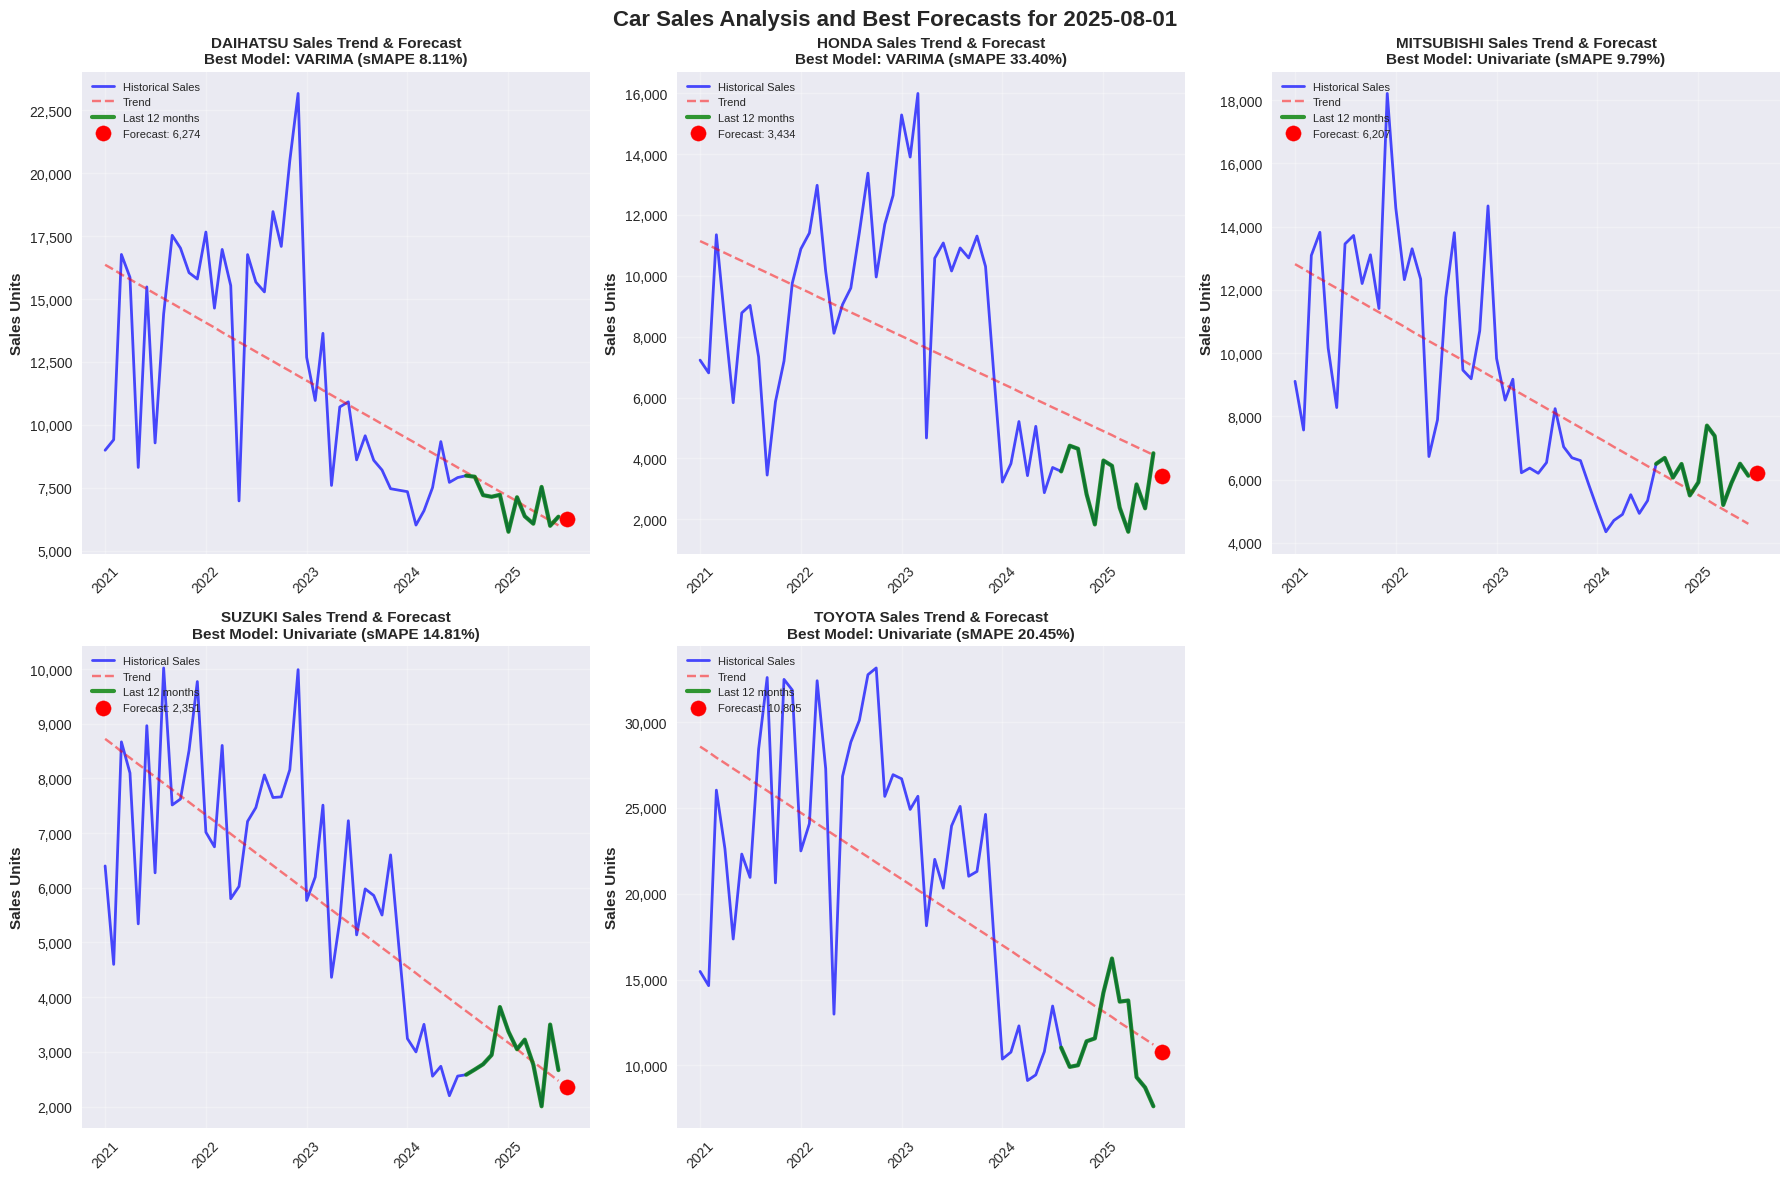

In [ ]:
def visualize_forecasts():
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Car Sales Analysis and Best Forecasts for 2025-08-01',
                 fontsize=16, fontweight='bold')

    brands = df.columns

    for i, brand in enumerate(brands):
        ax = axes[i//3, i%3]

        ax.plot(df.index, df[brand], 'b-', linewidth=2,
                label='Historical Sales', alpha=0.7)

        x_numeric = np.arange(len(df))
        z = np.polyfit(x_numeric, df[brand], 1)
        p = np.poly1d(z)
        ax.plot(df.index, p(x_numeric), 'r--', alpha=0.5, label='Trend')

        recent_data = df[brand][-12:]
        ax.plot(recent_data.index, recent_data.values, 'g-', linewidth=3,
                alpha=0.8, label='Last 12 months')

        forecast_date = pd.Timestamp('2025-08-01')
        if brand in final_forecasts and final_forecasts[brand] is not None:
            best_value = final_forecasts[brand]
            best_method = None
            best_smape = None
            for method, brand_scores in forecast_summary.items():
                smape = brand_scores.get(brand, np.inf)
                if smape != np.inf and (best_smape is None or smape < best_smape):
                    best_method = method
                    best_smape = smape

            ax.scatter([forecast_date], [best_value],
                       color='red', s=120, zorder=5, marker='o',
                       label=f'Forecast: {best_value:,}')

            ax.set_title(f'{brand} Sales Trend & Forecast\n'
                         f'Best Model: {best_method} (sMAPE {best_smape:.2f}%)',
                         fontweight='bold', fontsize=11)
        else:
            ax.set_title(f'{brand} Sales Trend & Forecast',
                         fontweight='bold', fontsize=11)

        ax.set_ylabel('Sales Units')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)

        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    if len(brands) < 6:
        fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.show()

visualize_forecasts()

# Saving Result

2025-09-07 02:38:16,351 - root - INFO - 💾 Saving results...
2025-09-07 02:38:16,360 - root - INFO - ✅ Final forecasts saved to results/final_forecast_2025-08.csv
2025-09-07 02:38:16,363 - root - INFO - ✅ All method forecasts saved to results/all_method_forecasts_2025-08.csv
2025-09-07 02:38:16,366 - root - INFO - ✅ Model performance summary saved to results/model_performance_summary.csv
2025-09-07 02:38:16,371 - root - INFO - ✅ Univariate model ranking saved to results/univariate_model_ranking.csv
2025-09-07 02:38:16,376 - root - INFO - ✅ Trained model saved to results/models/best_univariate_models.pkl
2025-09-07 02:38:16,382 - root - INFO - ✅ Trained model saved to results/models/varima_model.pkl
2025-09-07 02:38:16,404 - root - INFO - ✅ Trained model saved to results/models/xgboost_model.pkl
2025-09-07 02:38:19,077 - root - INFO - ✅ Forecast visualization saved to results/forecast_visualization_2025-08.png


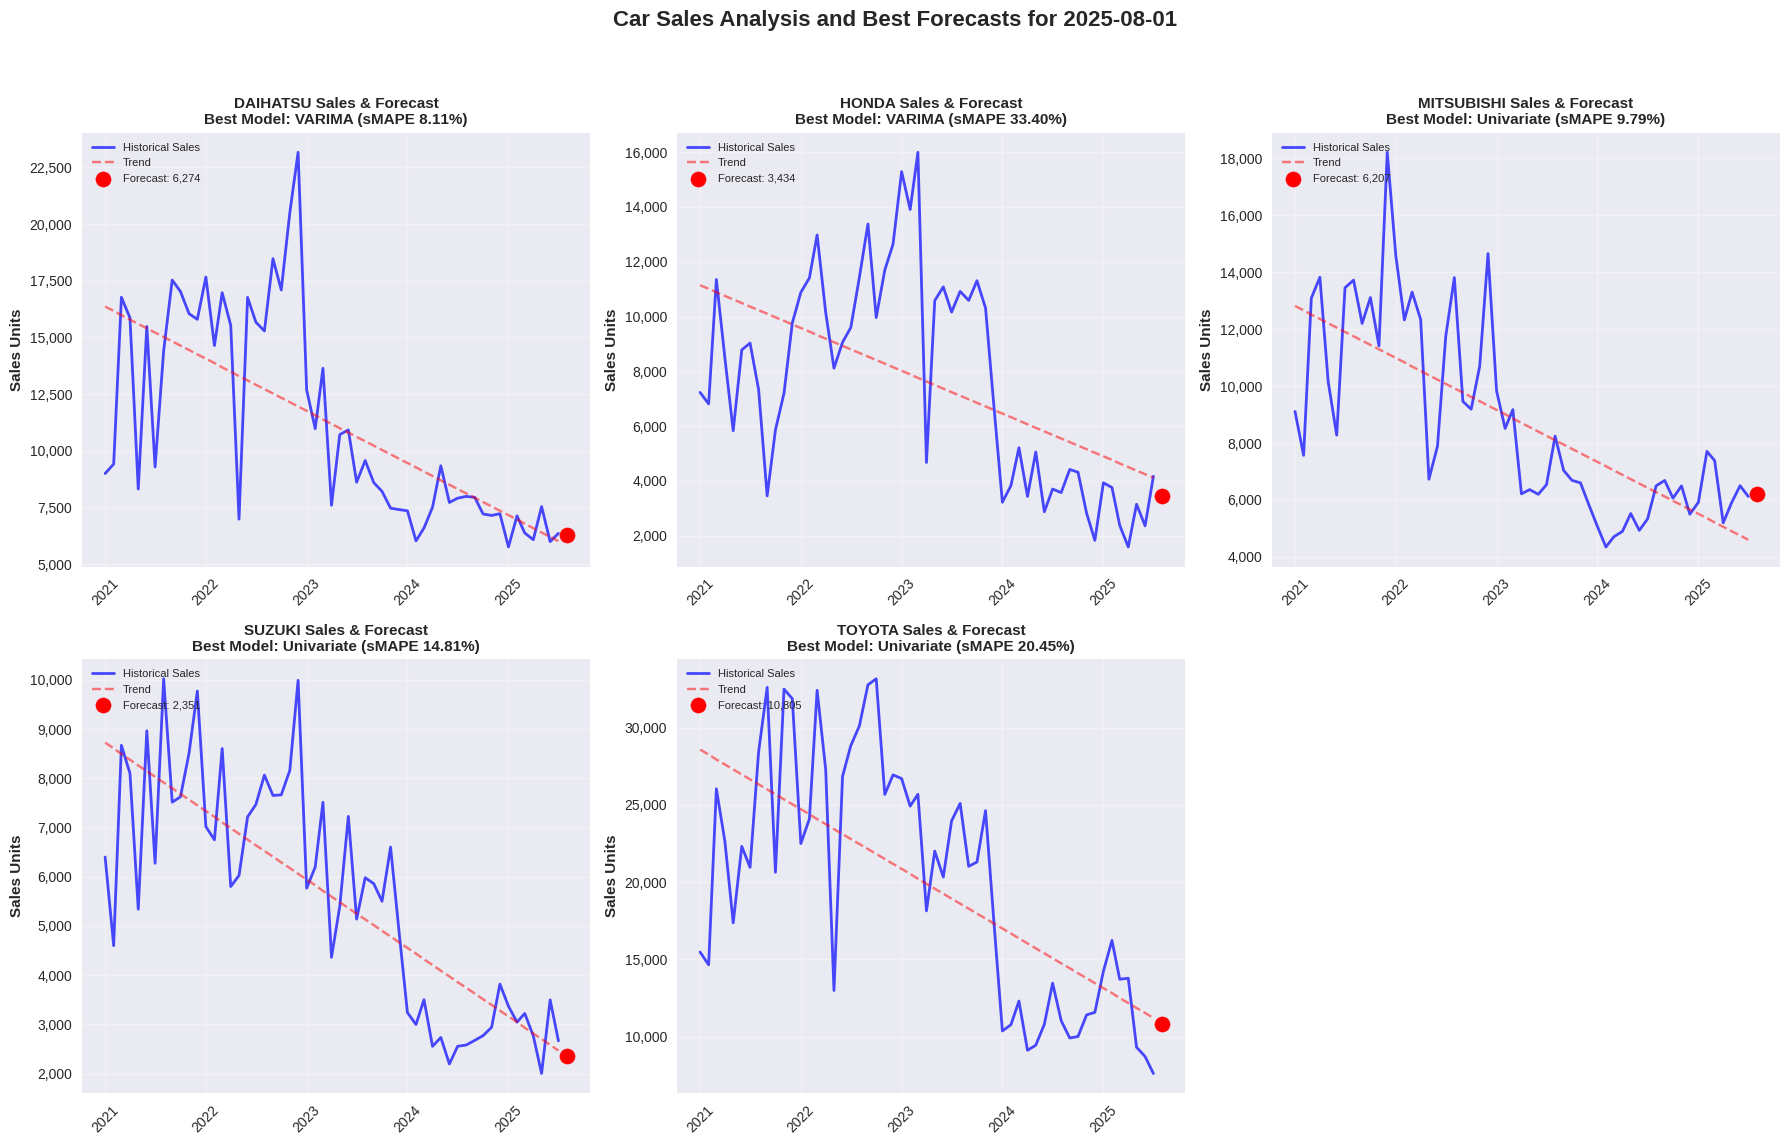

In [ ]:

logger.info("💾 Saving results...")

if 'final_forecasts' in locals() and final_forecasts:
    try:
        final_forecast_df = pd.DataFrame([final_forecasts])
        final_forecast_df = final_forecast_df.T.rename(columns={0: 'Forecast_August_2025'})
        final_forecast_df.index.name = 'Brand'
        final_forecast_path = "results/final_forecast_2025-08.csv"
        final_forecast_df.to_csv(final_forecast_path)
        logger.info(f"✅ Final forecasts saved to {final_forecast_path}")
    except Exception as e:
        logger.error(f"❌ Failed to save final forecasts: {e}")

if 'ensemble_forecasts' in locals() and ensemble_forecasts:
    try:
        ensemble_df = pd.DataFrame(ensemble_forecasts)
        ensemble_path = "results/all_method_forecasts_2025-08.csv"
        ensemble_df.to_csv(ensemble_path)
        logger.info(f"✅ All method forecasts saved to {ensemble_path}")
    except Exception as e:
        logger.error(f"❌ Failed to save ensemble forecasts: {e}")

if 'forecast_summary' in locals() and forecast_summary:
    try:
        summary_df = pd.DataFrame(forecast_summary).T
        summary_path = "results/model_performance_summary.csv"
        summary_df.to_csv(summary_path)
        logger.info(f"✅ Model performance summary saved to {summary_path}")
    except Exception as e:
        logger.error(f"❌ Failed to save performance summary: {e}")

if 'results_df' in locals() and not results_df.empty:
    try:
        avg_performance = results_df.groupby('model')['sMAPE'].agg(['mean', 'std']).round(2).sort_values('mean')
        ranking_path = "results/univariate_model_ranking.csv"
        avg_performance.to_csv(ranking_path)
        logger.info(f"✅ Univariate model ranking saved to {ranking_path}")
    except Exception as e:
        logger.error(f"❌ Failed to save univariate model ranking: {e}")

model_saves = {
    'best_univariate_models.pkl': best_models_dict if 'best_models_dict' in locals() else None,
    'varima_model.pkl': varima_results if 'varima_results' in locals() else None,
    'xgboost_model.pkl': xgb_results if 'xgb_results' in locals() else None
}

for filename, model_dict in model_saves.items():
    if model_dict:
        try:
            path = f"results/models/{filename}"
            with open(path, 'wb') as f:
                pickle.dump(model_dict, f)
            logger.info(f"✅ Trained model saved to {path}")
        except Exception as e:
            logger.error(f"❌ Failed to save {filename}: {e}")


def visualize_and_save_forecasts(save_path="results/forecast_visualization_2025-08.png"):
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Car Sales Analysis and Best Forecasts for 2025-08-01',
                 fontsize=16, fontweight='bold')

    brands = df.columns
    for i, brand in enumerate(brands):
        ax = axes[i//3, i%3]
        ax.plot(df.index, df[brand], 'b-', linewidth=2, label='Historical Sales', alpha=0.7)

        x_numeric = range(len(df))
        z = np.polyfit(x_numeric, df[brand], 1)
        p = np.poly1d(z)
        ax.plot(df.index, p(x_numeric), 'r--', alpha=0.5, label='Trend')

        forecast_date = pd.Timestamp('2025-08-01')
        if brand in final_forecasts and final_forecasts[brand] is not None:
            best_value = final_forecasts[brand]
            ax.scatter([forecast_date], [best_value], color='red', s=120, zorder=5, marker='o',
                       label=f'Forecast: {best_value:,}')

            best_method = min(forecast_summary, key=lambda m: forecast_summary[m].get(brand, float('inf')))
            best_smape = forecast_summary[best_method].get(brand)
            ax.set_title(f'{brand} Sales & Forecast\nBest Model: {best_method} (sMAPE {best_smape:.2f}%)',
                         fontweight='bold', fontsize=11)
        else:
            ax.set_title(f'{brand} Sales Trend & Forecast', fontweight='bold', fontsize=11)

        ax.set_ylabel('Sales Units')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    if len(brands) < 6:
        fig.delaxes(axes[1, 2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    try:
        plt.savefig(save_path, dpi=300)
        logger.info(f"✅ Forecast visualization saved to {save_path}")
    except Exception as e:
        logger.error(f"❌ Failed to save visualization: {e}")
    plt.show()

visualize_and_save_forecasts()